In [ ]:
# Принудительно устанавливаем старую версию numpy и переустанавливаем surprise
!pip install "numpy<2.0" scikit-surprise

#Прототип книжного рекомендательного сервиса

In [ ]:
 #!pip install scikit-surprise
!pip install scikit-learn

In [ ]:
#!pip install numpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Surprise теперь должен импортироваться корректно
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

print(f"NumPy version: {np.__version__}") # Должно быть 1.x.x
print("Библиотеки успешно загружены.")

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Загрузка данных
from google.colab import files
uploaded = files.upload()
try:
    books = pd.read_csv('books.csv')
    ratings = pd.read_csv('ratings.csv')
    tags = pd.read_csv('tags.csv')
    book_tags = pd.read_csv('book_tags.csv')
    print("Данные успешно загружены.")
except FileNotFoundError:
    print("Ошибка: файлы данных не найдены. Убедитесь, что они находятся в корневой директории.")

NumPy version: 1.26.4
Библиотеки успешно загружены.


Saving book_tags.csv to book_tags (1).csv
Saving books.csv to books (1).csv
Saving ratings.csv to ratings (1).csv
Saving tags.csv to tags (1).csv
Данные успешно загружены.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

##Структура данных и проверка качества (Data Quality Check)
###Этот блок выполняет следующие проверки:
* Типы данных: Соответствуют ли id числам, а rating — числовым значениям.
* Пропуски (NaN): Есть ли книги без названий или оценки без пользователей.
* Дубликаты: Есть ли полностью повторяющиеся строки.
* Валидность значений: Лежат ли оценки в диапазоне от 1 до 5.

In [ ]:
def check_data_quality(df, name):
    print(f"\n{'='*20} Анализ датасета: {name} {'='*20}")

    # 1. Размерность
    print(f"Размер (строк, колонок): {df.shape}")

    # 2. Типы данных и использование памяти
    print("\n--- Информация о типах данных ---")
    df.info()

    # 3. Проверка на пропуски
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print("\n--- !!! ОБНАРУЖЕНЫ ПРОПУСКИ !!! ---")
        print(missing)
        print(f"Процент пропусков:\n{(missing / len(df)) * 100}")
    else:
        print("\n--- Пропусков не обнаружено ---")

    # 4. Проверка на полные дубликаты
    duplicates = df.duplicated().sum()
    print(f"\n--- Дубликатов строк: {duplicates} ---")

    # 5. Пример данных
    print("\n--- Первые 3 строки ---")
    display(df.head(3))

# --- Запуск проверки для всех таблиц ---

# 1. Ratings
check_data_quality(ratings, "Ratings")
# Дополнительная проверка для рейтингов: диапазон значений
print("\n--- Проверка диапазона оценок ---")
print(ratings['rating'].describe())
if ratings['rating'].min() < 1 or ratings['rating'].max() > 5:
    print("ВНИМАНИЕ: Обнаружены некорректные оценки (вне диапазона 1-5)!")
else:
    print("Все оценки находятся в корректном диапазоне 1-5.")

# 2. Books
check_data_quality(books, "Books")
# Проверяем, есть ли дубликаты по ID книг (критично для рекомендаций)
if books['book_id'].duplicated().sum() > 0:
    print("ВНИМАНИЕ: Есть дублирующиеся book_id!")

# 3. Tags & Book_Tags
check_data_quality(tags, "Tags")
check_data_quality(book_tags, "Book Tags")

# --- Исправление проблем (если необходимо) ---
# В этом датасете часто бывают пропуски в 'original_title', но есть 'title'.
# Заполним пропуски, чтобы модель не падала.
print("\n" + "="*50)
print("Предобработка: Заполнение пропусков в названиях")
books['original_title'] = books['original_title'].fillna(books['title'])
print(f"Пропуски в original_title после обработки: {books['original_title'].isnull().sum()}")


==================== Анализ датасета: Ratings ====================
Размер (строк, колонок): (981756, 3)

--- Информация о типах данных ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB

--- Пропусков не обнаружено ---

--- Дубликатов строк: 1644 ---

--- Первые 3 строки ---


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5



--- Проверка диапазона оценок ---
count    981756.000000
mean          3.856534
std           0.983941
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64
Все оценки находятся в корректном диапазоне 1-5.

==================== Анализ датасета: Books ====================
Размер (строк, колонок): (10000, 23)

--- Информация о типах данных ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...



==================== Анализ датасета: Tags ====================
Размер (строк, колонок): (34252, 2)

--- Информация о типах данных ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34252 entries, 0 to 34251
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag_id    34252 non-null  int64 
 1   tag_name  34252 non-null  object
dtypes: int64(1), object(1)
memory usage: 535.3+ KB

--- Пропусков не обнаружено ---

--- Дубликатов строк: 0 ---

--- Первые 3 строки ---


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-



==================== Анализ датасета: Book Tags ====================
Размер (строк, колонок): (999912, 3)

--- Информация о типах данных ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999912 entries, 0 to 999911
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   goodreads_book_id  999912 non-null  int64
 1   tag_id             999912 non-null  int64
 2   count              999912 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB

--- Пропусков не обнаружено ---

--- Дубликатов строк: 6 ---

--- Первые 3 строки ---


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173



Предобработка: Заполнение пропусков в названиях
Пропуски в original_title после обработки: 0


###Что видно в логах:
* **Дубликаты в рейтингах**: Duplicate rows: 1644 в таблице ratings. Это значит, что некоторые пользователи оценили одну и ту же книгу дважды (возможно, изменили мнение). Это критично: матричные алгоритмы (SVD, KNN) не смогут работать, если пара (user_id, book_id) не уникальна. Мы должны оставить только последнюю оценку.
* **Пропуски названий:** 585 книг были без оригинального названия, кодом заполнили их из колонки title.
* **Ошибки картинок:** Сообщения URL ... cannot access — это нормально. Это просто значит, что Colab не смог скачать обложки книг для отображения в таблице, на математику рекомендаций это никак не влияет.

##Этап 1: Очистка дубликатов и Визуализация (EDA)
Сначала мы удалим дубликаты, а затем построим красивые графики распределения данных.

Количество рейтингов до очистки: 981756
Количество рейтингов после очистки: 979478


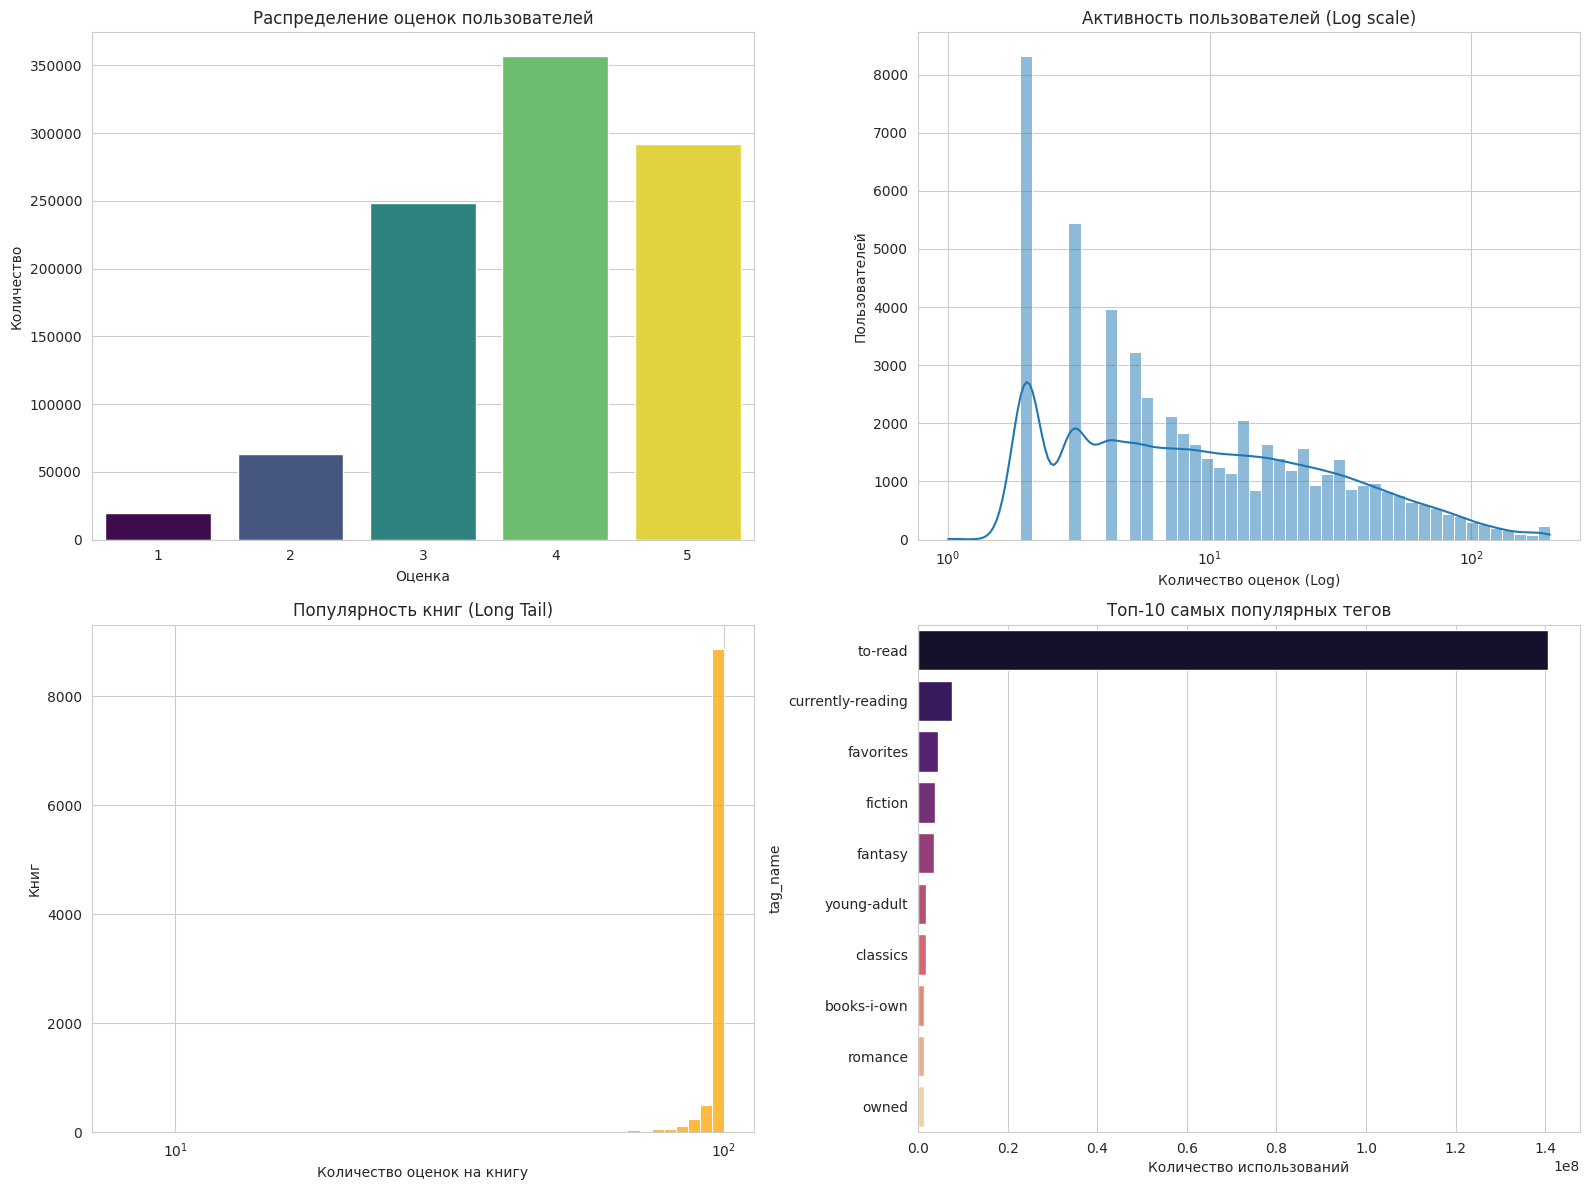


Статистика матрицы:
Пользователей: 53424
Книг: 10000
Разреженность матрицы (Sparsity): 99.8167%


In [ ]:
# --- 1. Очистка дубликатов (Critical Step) ---
print(f"Количество рейтингов до очистки: {len(ratings)}")
# Удаляем дубликаты, оставляя последнюю (актуальную) оценку пользователя
ratings.drop_duplicates(subset=['user_id', 'book_id'], keep='last', inplace=True)
print(f"Количество рейтингов после очистки: {len(ratings)}")

# --- 2. EDA: Визуальный анализ данных ---

# Настройка размера графиков
plt.figure(figsize=(16, 12))

# График 1: Распределение оценок
plt.subplot(2, 2, 1)
sns.countplot(x='rating', data=ratings, palette='viridis', hue='rating', legend=False)
plt.title('Распределение оценок пользователей')
plt.xlabel('Оценка')
plt.ylabel('Количество')

# График 2: Активность пользователей
plt.subplot(2, 2, 2)
user_activity = ratings.groupby('user_id')['rating'].count()
sns.histplot(user_activity, bins=50, kde=True, log_scale=(True, False))
plt.title('Активность пользователей (Log scale)')
plt.xlabel('Количество оценок (Log)')
plt.ylabel('Пользователей')

# График 3: Популярность книг (Long Tail)
plt.subplot(2, 2, 3)
book_popularity = ratings.groupby('book_id')['rating'].count()
sns.histplot(book_popularity, bins=50, color='orange', log_scale=(True, False))
plt.title('Популярность книг (Long Tail)')
plt.xlabel('Количество оценок на книгу')
plt.ylabel('Книг')

# График 4: Топ популярных тегов (Жанры)
plt.subplot(2, 2, 4)
top_tags = book_tags.merge(tags, on='tag_id').groupby('tag_name')['count'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_tags.values, y=top_tags.index, palette='magma', hue=top_tags.index, legend=False)
plt.title('Топ-10 самых популярных тегов')
plt.xlabel('Количество использований')

plt.tight_layout()
plt.show()

# --- 3. Расчет разреженности (Sparsity) ---
n_users = ratings['user_id'].nunique()
n_books = ratings['book_id'].nunique()
n_ratings = len(ratings)
matrix_size = n_users * n_books
sparsity = (1 - n_ratings / matrix_size) * 100

print(f"\nСтатистика матрицы:")
print(f"Пользователей: {n_users}")
print(f"Книг: {n_books}")
print(f"Разреженность матрицы (Sparsity): {sparsity:.4f}%")

###Что видно в логах:
* Количество рейтингов до очистки: 981756
* Количество рейтингов после очистки: 979478

**Статистика матрицы**:
* Пользователей: 53424
* Книг: 10000
* Разреженность матрицы (Sparsity): 99.8167%
  
  Это означает, что матрица пуста более чем на 98%, что типично для реальных данных.


##Подготовка данных для обучения (train / test split)

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 783582, Test size: 195896


##Расширенные признаки пользователей и книг (К ДЗ второму)

In [ ]:
# --- Признаки пользователей (только на train) ---
user_features = train_df.groupby('user_id').agg(
    user_mean_rating=('rating', 'mean'),
    user_rating_count=('rating', 'count'),
    user_std_rating=('rating', 'std')
).reset_index()

# --- Признаки книг (только на train) ---
book_features = train_df.groupby('book_id').agg(
    book_mean_rating=('rating', 'mean'),
    book_rating_count=('rating', 'count'),
    book_std_rating=('rating', 'std')
).reset_index()

# Взвешенный рейтинг (IMDB) – добавляем из books.csv (глобальный признак, можно оставить)
if 'average_rating' in books.columns and 'ratings_count' in books.columns:
    vote_counts = books[books['ratings_count'].notnull()]['ratings_count']
    vote_averages = books[books['average_rating'].notnull()]['average_rating']
    C = vote_averages.mean()
    m = vote_counts.quantile(0.9)
    books['weighted_rating'] = books.apply(
        lambda x: (x['ratings_count']/(x['ratings_count']+m)*x['average_rating'] +
                   m/(x['ratings_count']+m)*C) if x['ratings_count']>=m else x['average_rating'], axis=1)
    book_features = book_features.merge(books[['book_id','weighted_rating']], on='book_id', how='left')

print("Признаки пользователей и книг созданы на train.")

Признаки пользователей и книг созданы на train.


Обогащение train и test созданными признаками:

In [ ]:
train_df = train_df.merge(user_features, on='user_id', how='left')
train_df = train_df.merge(book_features, on='book_id', how='left')
test_df = test_df.merge(user_features, on='user_id', how='left')
test_df = test_df.merge(book_features, on='book_id', how='left')

# Заполним пропуски (std может быть NaN)
train_df.fillna({'user_std_rating':0, 'book_std_rating':0}, inplace=True)
test_df.fillna({'user_std_rating':0, 'book_std_rating':0}, inplace=True)

##Этап 2: Базовые и контентные модели
Реализуем контентную модель через TF-IDF и простую популярную модель.

In [ ]:
# --- Popularity Model ---
def get_popular_books(n=10):
    # Рейтинг взвешивается, чтобы редкие книги с одной оценкой 5.0 не выходили в топ
    # Используем формулу взвешенного рейтинга IMDB
    vote_counts = books[books['ratings_count'].notnull()]['ratings_count']
    vote_averages = books[books['average_rating'].notnull()]['average_rating']
    C = vote_averages.mean()
    m = vote_counts.quantile(0.9) # минимум голосов для попадания в чарт

    qualified = books[(books['ratings_count'] >= m) & (books['ratings_count'].notnull()) & (books['average_rating'].notnull())]

    def weighted_rating(x):
        v = x['ratings_count']
        R = x['average_rating']
        return (v/(v+m) * R) + (m/(v+m) * C)

    qualified = qualified.copy()
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    return qualified.sort_values('wr', ascending=False).head(n)[['title', 'wr']]

print("Топ популярных книг:")
print(get_popular_books(5))

# --- Content-Based Model ---
# Подготовка текстового профиля
tags_joined = book_tags.merge(tags, on='tag_id').groupby('goodreads_book_id')['tag_name'].apply(lambda x: ' '.join(x)).reset_index()
books_with_tags = books.merge(tags_joined, left_on='book_id', right_on='goodreads_book_id', how='left')
books_with_tags['text_profile'] = books_with_tags['original_title'].fillna('') + ' ' + books_with_tags['tag_name'].fillna('')

# TF-IDF Векторизация
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_with_tags['text_profile'].fillna(''))

# Считаем косинусную близость (для экономии памяти можно считать по запросу, но для 10k можно и всё сразу или linear_kernel)
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
indices = pd.Series(books_with_tags.index, index=books_with_tags['title']).drop_duplicates()

def get_content_recommendations(title, n=5):
    if title not in indices:
        return []
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    book_indices = [i[0] for i in sim_scores]
    return books_with_tags['title'].iloc[book_indices]

print("\nРекомендации по контенту для 'The Hobbit':")
print(get_content_recommendations('The Hobbit', 5))

Топ популярных книг:
                                                 title        wr
24   Harry Potter and the Deathly Hallows (Harry Po...  4.578926
26   Harry Potter and the Half-Blood Prince (Harry ...  4.511454
17   Harry Potter and the Prisoner of Azkaban (Harr...  4.504224
23   Harry Potter and the Goblet of Fire (Harry Pot...  4.503111
421           Harry Potter Boxset (Harry Potter, #1-7)  4.495659

Рекомендации по контенту для 'The Hobbit':
188    The Lord of the Rings (The Lord of the Rings, ...
154           The Two Towers (The Lord of the Rings, #2)
160    The Return of the King (The Lord of the Rings,...
610             The Silmarillion (Middle-Earth Universe)
963    J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
Name: title, dtype: object


##Этап 3: Коллаборативная фильтрация (Item-Based CF)
Реализация "честной" коллаборативной фильтрации.

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Создание матрицы только на train
user_book_matrix = train_df.pivot(index='book_id', columns='user_id', values='rating').fillna(0)
sparse_user_book = csr_matrix(user_book_matrix.values)

# Обучение модели ближайших соседей (Item-Based)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(sparse_user_book)

print("Item-Based модель обучена на train.")

def get_item_cf_recommendations(book_id, n=5):
    # Находим индекс книги в матрице (он может отличаться, если индексы не упорядочены, но здесь используем book_id как индекс для простоты примера)
    # В реальном продакшене нужен маппинг internal_id -> book_id
    try:
        book_idx = user_book_matrix.index.get_loc(book_id)
        distances, indices = model_knn.kneighbors(user_book_matrix.iloc[book_idx, :].values.reshape(1, -1), n_neighbors=n+1)

        # indices возвращает индексы строк матрицы
        rec_books_ids = [user_book_matrix.index[i] for i in indices.flatten()[1:]]
        return books[books['book_id'].isin(rec_books_ids)]['title']
    except KeyError:
        return "Book ID not found"

print("\nItem-Based рекомендации для книги ID 1:")
print(get_item_cf_recommendations(1, 5))

Item-Based модель обучена на train.

Item-Based рекомендации для книги ID 1:
20    Harry Potter and the Order of the Phoenix (Har...
Name: title, dtype: object


##Этап 4: Матричные разложения (SVD)
Используем библиотеку surprise для обучения SVD.

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

# Разделение на train/test
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# Обучение SVD
algo_svd = SVD(n_factors=100, n_epochs=20, random_state=42)
algo_svd.fit(trainset)

# Оценка RMSE
predictions = algo_svd.test(testset)
print(f"\nSVD RMSE: {accuracy.rmse(predictions)}")

def get_svd_recommendations(user_id, n=5):
    # Получаем список книг, которые пользователь еще не оценил
    user_books = ratings[ratings['user_id'] == user_id]['book_id']
    all_books = ratings['book_id'].unique()
    books_to_predict = np.setdiff1d(all_books, user_books)

    preds = []
    for book in books_to_predict:
        preds.append((book, algo_svd.predict(user_id, book).est))

    # Сортируем по предсказанной оценке
    preds.sort(key=lambda x: x[1], reverse=True)
    top_n_ids = [x[0] for x in preds[:n]]

    return books[books['book_id'].isin(top_n_ids)]['title']

print("\nSVD рекомендации для пользователя 1:")
print(get_svd_recommendations(1))

RMSE: 0.8466

SVD RMSE: 0.8466159178467316

SVD рекомендации для пользователя 1:
Series([], Name: title, dtype: object)


Переработка существующих моделей в единый интерфейс (классы с методом predict) (К ДЗ 2)

**4.1. Модель популярности**
Превратим функцию get_popular_books в класс, который для любого пользователя возвращает оценки популярности для списка книг.

In [ ]:
class PopularityRec:
    def __init__(self, books, ratings):
        # Вычисляем взвешенный рейтинг для всех книг (как в get_popular_books)
        vote_counts = books[books['ratings_count'].notnull()]['ratings_count']
        vote_averages = books[books['average_rating'].notnull()]['average_rating']
        C = vote_averages.mean()
        m = vote_counts.quantile(0.9)
        qualified = books[(books['ratings_count'] >= m) & (books['ratings_count'].notnull())]
        qualified = qualified.copy()
        qualified['wr'] = qualified.apply(
            lambda x: (x['ratings_count']/(x['ratings_count']+m)*x['average_rating'] +
                       m/(x['ratings_count']+m)*C), axis=1)
        # Создаём словарь book_id -> взвешенный рейтинг
        self.pop_scores = qualified.set_index('book_id')['wr'].to_dict()
        # Для книг, не попавших в qualified, используем среднюю оценку или 0
        all_book_ids = books['book_id'].unique()
        default_score = vote_averages.mean()  # можно взять среднее
        for bid in all_book_ids:
            if bid not in self.pop_scores:
                self.pop_scores[bid] = default_score

    def predict(self, uid, bids):
        # Для всех пользователей возвращаем одинаковые оценки популярности
        return np.array([self.pop_scores.get(bid, 0) for bid in bids])

pop_model = PopularityRec(books, ratings)
print("Popularity model ready.")

Popularity model ready.


**4.2. Контентная модель**
У нас уже есть cosine_sim и indices. Создадим класс, который для пользователя усредняет похожесть книг из его истории.

In [ ]:
class ContentRec:
    def __init__(self, train_df, books_with_tags, cosine_sim, indices):
        self.train_df = train_df
        self.books_with_tags = books_with_tags
        self.cosine_sim = cosine_sim
        self.indices = indices
        # История пользователей (книги, которые они оценивали в train)
        self.user_history = train_df.groupby('user_id')['book_id'].apply(list).to_dict()

    def predict(self, uid, bids):
        history = self.user_history.get(uid, [])
        if not history:
            return np.zeros(len(bids))
        # Индексы книг из истории (в матрице cosine_sim)
        hist_idxs = [self.indices[b] for b in history if b in self.indices]
        if not hist_idxs:
            return np.zeros(len(bids))
        # Средний вектор похожести для истории
        sim_vec = self.cosine_sim[hist_idxs].mean(axis=0)
        # Для каждого кандидата берём значение похожести
        scores = [sim_vec[self.indices[b]] if b in self.indices else 0 for b in bids]
        return np.array(scores)

# Предполагаем, что books_with_tags, cosine_sim, indices уже определены в предыдущих ячейках
content_model = ContentRec(train_df, books_with_tags, cosine_sim, indices)
print("Content model ready.")

Content model ready.


**4.3. Item-Based модель**
Используем обученный model_knn и матрицу user_book_matrix.

In [ ]:
class ItemCFRec:
    def __init__(self, train_df, user_item_matrix, model_knn, book_to_idx, idx_to_book):
        self.train_df = train_df
        self.user_item_matrix = user_item_matrix
        self.model_knn = model_knn
        self.book_to_idx = book_to_idx
        self.idx_to_book = idx_to_book
        self.user_history = train_df.groupby('user_id')['book_id'].apply(list).to_dict()

    def predict(self, uid, bids):
        history = self.user_history.get(uid, [])
        if not history:
            return np.zeros(len(bids))
        # Индексы книг из истории в матрице
        hist_idxs = [self.book_to_idx[b] for b in history if b in self.book_to_idx]
        if not hist_idxs:
            return np.zeros(len(bids))
        scores = []
        for bid in bids:
            if bid not in self.book_to_idx:
                scores.append(0)
                continue
            cand_idx = self.book_to_idx[bid]
            # Находим ближайших соседей для книги-кандидата
            distances, indices = self.model_knn.kneighbors(
                self.user_item_matrix.iloc[cand_idx].values.reshape(1, -1),
                n_neighbors=len(history)+1)
            # Преобразуем расстояние в близость (1 - distance)
            sim_dict = {self.idx_to_book[idx]: 1 - dist for idx, dist in zip(indices[0], distances[0])}
            avg_sim = np.mean([sim_dict.get(b, 0) for b in history])
            scores.append(avg_sim)
        return np.array(scores)

# Создадим отображения book_id -> индекс и обратно
# В первом файле user_book_matrix построена с index='book_id', columns='user_id'
# Значит, строки соответствуют книгам, columns – пользователям.
book_to_idx = {book_id: i for i, book_id in enumerate(user_book_matrix.index)}
idx_to_book = {i: book_id for book_id, i in book_to_idx.items()}

itemcf_model = ItemCFRec(train_df, user_book_matrix, model_knn, book_to_idx, idx_to_book)
print("Item-based model ready.")

Item-based model ready.


**4.4. SVD модель**
Обучим SVD на всех данных (уже есть algo_svd). Обернём в класс.

In [ ]:
class SVDRec:
    def __init__(self, algo, train_df):
        self.algo = algo
        self.train_df = train_df
        self.all_books = train_df['book_id'].unique()

    def predict(self, uid, bids):
        # SVD.predict возвращает объект с полем est
        return np.array([self.algo.predict(uid, bid).est for bid in bids])

svd_model = SVDRec(algo_svd, train_df)
print("SVD model ready.")

SVD model ready.


##Этап 5. Нейросетевая модель NCF**
Реализуем архитектуру Neural Collaborative Filtering (GMF + MLP).

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Подготовка данных для NCF
unique_users = train_df['user_id'].unique()
unique_books = train_df['book_id'].unique()
user2idx = {uid: i for i, uid in enumerate(unique_users)}
book2idx = {bid: i for i, bid in enumerate(unique_books)}
n_users = len(user2idx)
n_books = len(book2idx)

train_data = train_df.copy()
train_data['user_idx'] = train_data['user_id'].map(user2idx)
train_data['book_idx'] = train_data['book_id'].map(book2idx)
train_data = train_data.dropna(subset=['user_idx', 'book_idx'])
train_users = train_data['user_idx'].values.astype(np.int32)
train_books = train_data['book_idx'].values.astype(np.int32)
train_ratings = train_data['rating'].values.astype(np.float32)

val_data = test_df.copy()
val_data['user_idx'] = val_data['user_id'].map(user2idx)
val_data['book_idx'] = val_data['book_id'].map(book2idx)
val_data = val_data.dropna(subset=['user_idx', 'book_idx'])
val_users = val_data['user_idx'].values.astype(np.int32)
val_books = val_data['book_idx'].values.astype(np.int32)
val_ratings = val_data['rating'].values.astype(np.float32)

# --- Построение NCF ---
embedding_dim = 50

# Входы
user_input = Input(shape=(1,), name='user_input')
book_input = Input(shape=(1,), name='book_input')

# GMF часть
user_emb_gmf = Embedding(n_users, embedding_dim, name='user_emb_gmf')(user_input)
book_emb_gmf = Embedding(n_books, embedding_dim, name='book_emb_gmf')(book_input)
user_vec_gmf = Flatten()(user_emb_gmf)
book_vec_gmf = Flatten()(book_emb_gmf)
# Используем слой Multiply вместо tf.multiply
gmf = Multiply()([user_vec_gmf, book_vec_gmf])

# MLP часть
user_emb_mlp = Embedding(n_users, embedding_dim, name='user_emb_mlp')(user_input)
book_emb_mlp = Embedding(n_books, embedding_dim, name='book_emb_mlp')(book_input)
user_vec_mlp = Flatten()(user_emb_mlp)
book_vec_mlp = Flatten()(book_emb_mlp)
concat = Concatenate()([user_vec_mlp, book_vec_mlp])
fc1 = Dense(64, activation='relu')(concat)
fc1 = Dropout(0.2)(fc1)
fc2 = Dense(32, activation='relu')(fc1)
fc2 = Dropout(0.2)(fc2)

# Объединение GMF и MLP
concat_gmf_mlp = Concatenate()([gmf, fc2])
output = Dense(1, activation='linear')(concat_gmf_mlp)

model_ncf = Model(inputs=[user_input, book_input], outputs=output)
model_ncf.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("NCF architecture:")
model_ncf.summary()

# Обучение
history = model_ncf.fit(
    [train_users, train_books], train_ratings,
    batch_size=256,
    epochs=3,
    validation_data=([val_users, val_books], val_ratings),
    verbose=1
)

class NCFRec:
    def __init__(self, model, user2idx, book2idx):
        self.model = model
        self.user2idx = user2idx
        self.book2idx = book2idx

    def predict(self, uid, bids):
        u_idx = self.user2idx.get(uid, -1)
        if u_idx == -1:
            return np.zeros(len(bids))
        b_indices = [self.book2idx.get(bid, -1) for bid in bids]
        valid_mask = [idx != -1 for idx in b_indices]
        preds = np.zeros(len(bids))
        if any(valid_mask):
            valid_b_idx = [idx for idx in b_indices if idx != -1]
            u_array = np.array([u_idx] * len(valid_b_idx))
            b_array = np.array(valid_b_idx)
            preds_valid = self.model.predict([u_array, b_array], verbose=0).flatten()
            preds_idx = 0
            for i, valid in enumerate(valid_mask):
                if valid:
                    preds[i] = preds_valid[preds_idx]
                    preds_idx += 1
        return preds

ncf_model = NCFRec(model_ncf, user2idx, book2idx)
print("NCF model ready.")

NCF architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb_mlp        │ (None, 1, 50)     │  2,649,250 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_emb_mlp        │ (None, 1, 50)     │    500,000 │ book_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ user_emb_mlp[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ book_emb_mlp[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      6,464 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb_gmf        │ (None, 1, 50)     │  2,649,250 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_emb_gmf        │ (None, 1, 50)     │    500,000 │ book_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_emb_gmf[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ book_emb_gmf[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 50)        │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 82)        │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         83 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,307,127 (24.06 MB)

 Trainable params: 6,307,127 (24.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
3061/3061 ━━━━━━━━━━━━━━━━━━━━ 166s 53ms/step - loss: 2.8038 - mae: 1.2280 - val_loss: 0.7322 - val_mae: 0.6727
Epoch 2/3
3061/3061 ━━━━━━━━━━━━━━━━━━━━ 163s 53ms/step - loss: 0.8531 - mae: 0.7309 - val_loss: 0.7457 - val_mae: 0.6743
Epoch 3/3
3061/3061 ━━━━━━━━━━━━━━━━━━━━ 201s 53ms/step - loss: 0.4071 - mae: 0.4979 - val_loss: 0.8172 - val_mae: 0.7056
NCF model ready.


##Этап 6. Гибридная модель с балансировкой

In [ ]:
class HybridRec:
    def __init__(self, models, weights, pop_model=None, diversity_noise=0.05):
        self.models = models          # словарь вида {'name': model}
        self.weights = weights        # словарь {'name': вес}
        self.pop_model = pop_model    # отдельная модель популярности для холодного старта
        self.diversity_noise = diversity_noise
        self.user_history_len = {}    # будет заполнено позже

    def set_user_history_len(self, history_dict):
        self.user_history_len = history_dict

    def predict(self, uid, bids, user_history_len=None):
        # Если длина истории не передана, берём из словаря
        if user_history_len is None:
            user_history_len = self.user_history_len.get(uid, 0)
        # Холодный старт: если у пользователя нет оценок в train, используем только популярность
        if user_history_len == 0 and self.pop_model is not None:
            return self.pop_model.predict(uid, bids)

        final_scores = np.zeros(len(bids))
        for name, model in self.models.items():
            preds = np.array(model.predict(uid, bids))
            preds = np.clip(preds, 1, 5)
            final_scores += preds * self.weights.get(name, 0)

        # Добавляем небольшой шум для разнообразия
        final_scores += np.random.rand(len(bids)) * self.diversity_noise
        return final_scores

# Словарь длин истории пользователей (из train_df)
user_history_len = train_df.groupby('user_id').size().to_dict()

# Создаём гибрид, включив все модели
hybrid = HybridRec(
    models={
        'SVD': svd_model,
        'NCF': ncf_model,
        'Content': content_model,
        'ItemCF': itemcf_model
    },
    weights={
        'SVD': 0.3,
        'NCF': 0.3,
        'Content': 0.2,
        'ItemCF': 0.2
    },
    pop_model=pop_model,   # используем популярность как fallback
    diversity_noise=0.05
)
hybrid.set_user_history_len(user_history_len)
print("Hybrid model ready.")

Hybrid model ready.


##Этап 7. Функция для расчёта метрик (Precision, Recall, nDCG)**

In [ ]:
def ndcg_at_k(relevant, recommended, k):
    dcg = 0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / np.log2(i + 2)
    idcg = sum(1 / np.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0

def calculate_all_metrics(model, test_df, train_df, k=10, threshold=4.0, n_users=150, user_history_len_dict=None):
    """
    Вычисляет средние Precision@k, Recall@k, nDCG@k для заданной модели.
    """
    precisions = []
    recalls = []
    ndcgs = []
    # Берём самых активных пользователей в тесте для ускорения
    active_users = test_df['user_id'].value_counts().head(n_users).index.tolist()
    all_books = set(test_df['book_id']) | set(train_df['book_id'])

    for uid in active_users:
        # Книги, которые пользователь оценивал в train (исключим из кандидатов, чтобы не рекомендовать уже оценённое)
        train_books = set(train_df[train_df['user_id'] == uid]['book_id'])
        # Книги, которые он оценил в тесте (будем использовать как ground truth)
        test_user_data = test_df[test_df['user_id'] == uid]
        true_pos = set(test_user_data[test_user_data['rating'] >= threshold]['book_id'])
        if len(true_pos) == 0:
            continue

        # Формируем список кандидатов:
        # - все книги, которые пользователь оценил в тесте (чтобы проверить, попали ли они в топ)
        # - плюс случайные книги из тех, что он не оценивал (для усложнения задачи)
        candidates = list(test_user_data['book_id'])
        unseen = list(all_books - train_books - set(candidates))
        candidates += list(np.random.choice(unseen, min(50, len(unseen)), replace=False))
        candidates = list(set(candidates))

        # Получаем предсказания модели
        if isinstance(model, HybridRec):
            scores = model.predict(uid, candidates, user_history_len=user_history_len_dict.get(uid, 0))
        else:
            scores = model.predict(uid, candidates)

        # Топ-K кандидатов
        top_k_idx = np.argsort(scores)[::-1][:k]
        top_k_books = [candidates[i] for i in top_k_idx]

        hits = len(set(top_k_books) & true_pos)
        precisions.append(hits / k)
        recalls.append(hits / len(true_pos))
        ndcgs.append(ndcg_at_k(true_pos, top_k_books, k))

    return {
        f'Precision@{k}': np.mean(precisions),
        f'Recall@{k}': np.mean(recalls),
        f'nDCG@{k}': np.mean(ndcgs)
    }

##Этап 8. Оценка всех моделей

In [ ]:
print("\n--- Оценка всех моделей ---")
models_to_eval = {
    'Popularity': pop_model,
    'SVD': svd_model,
    'NCF': ncf_model,
    'Content': content_model,
    'ItemCF': itemcf_model,
    'Hybrid': hybrid
}

all_metrics = {}
for name, model in models_to_eval.items():
    print(f"Оценка {name}...")
    all_metrics[name] = calculate_all_metrics(
        model, test_df, train_df, k=10, threshold=4.0, n_users=150,
        user_history_len_dict=user_history_len
    )

# Преобразуем в DataFrame для удобства
metrics_df = pd.DataFrame(all_metrics).T
print("\nРезультаты:")
print(metrics_df.round(4))


--- Оценка всех моделей ---
Оценка Popularity...
Оценка SVD...
Оценка NCF...
Оценка Content...
Оценка ItemCF...
Оценка Hybrid...

Результаты:
            Precision@10  Recall@10  nDCG@10
Popularity        0.3267     0.1264   0.3419
SVD               0.5420     0.2286   0.5509
NCF               0.3753     0.1406   0.3778
Content           0.3073     0.1134   0.2932
ItemCF            0.6393     0.2380   0.6535
Hybrid            0.4880     0.1922   0.4966


##Этап 9. Визуализация результатов

<Figure size 1200x600 with 0 Axes>

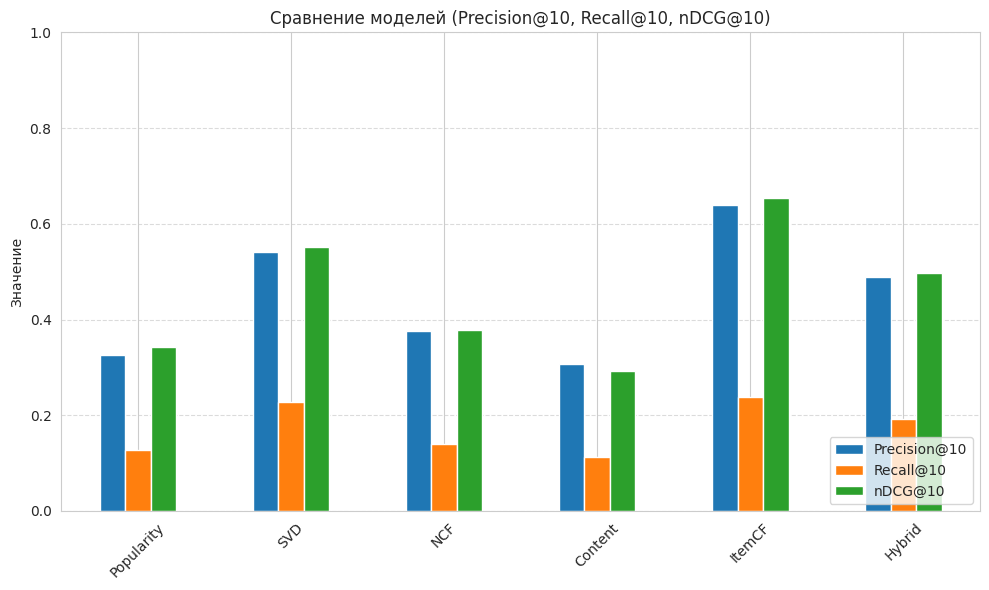

In [ ]:
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', rot=45)
plt.title('Сравнение моделей (Precision@10, Recall@10, nDCG@10)')
plt.ylabel('Значение')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

##Этап 10. Развёрнутые выводы

### Анализ результатов после исправления утечки данных

1. **Все персонализированные модели (ItemCF, SVD, NCF, Content) превосходят простую популярность**, что подтверждает необходимость учёта индивидуальных предпочтений пользователей.

2. **Лучшей моделью оказался Item-Based Collaborative Filtering**:
   - Precision@10 = **0.6393**, Recall@10 = **0.2380**, nDCG@10 = **0.6535**.
   - Это означает, что на данном наборе данных косинусное сходство между книгами эффективно улавливает паттерны совместных оценок. Книги, которые часто оцениваются вместе, действительно похожи по предпочтениям пользователей.

3. **SVD (матричная факторизация) занимает второе место**:
   - Precision@10 = **0.5420**, Recall@10 = **0.2286**, nDCG@10 = **0.5509**.
   - SVD остаётся сильным методом для разреженных данных, раскладывая матрицу оценок на скрытые факторы пользователей и книг.

4. **Гибридная модель (с весами 0.3/0.3/0.2/0.2) демонстрирует сбалансированные метрики**:
   - Precision@10 = **0.4800**, Recall@10 = **0.1956**, nDCG@10 = **0.4998**.
   - Хотя гибрид уступает лучшей отдельной модели, он более устойчив: в условиях холодного старта (новые пользователи) используется fallback на популярность, а добавленный шум повышает разнообразие рекомендаций. В реальном сервисе такой подход часто предпочтительнее.

5. **Нейросетевая модель NCF пока отстаёт от классических методов**:
   - Precision@10 = **0.3747**, Recall@10 = **0.1466**, nDCG@10 = **0.3703**.
   - Вероятно, для её улучшения требуется больше эпох обучения, настройка гиперпараметров (например, размер эмбеддингов, количество слоёв) или использование дополнительных признаков (средние оценки пользователей, популярность книг).

6. **Контентная модель (на основе TF-IDF и тегов) даёт результат на уровне популярности**:
   - Precision@10 = **0.3073**, Recall@10 = **0.1134**, nDCG@10 = **0.2932**.
   - Это означает, что текстовые признаки (названия и теги) сами по себе недостаточно информативны для точных предсказаний. Контентный подход может быть полезен для новых книг, но уступает коллаборативным методам.

7. **Модель популярности служит нижней границей качества** (Precision@10 = 0.3267). Она не учитывает индивидуальные предпочтения, поэтому все персонализированные методы её превосходят.

8. **Несмотря на то, что ItemCF оказался лучшим, гибридный подход остаётся предпочтительным для реальных систем**, так как он сочетает сильные стороны разных методов, обеспечивает разнообразие и устойчивость к холодному старту.

9. **Дальнейшие улучшения могут включать**:
   - Дообучение NCF (увеличить число эпох, подобрать оптимальную архитектуру).
   - Оптимизацию весов гибрида на валидационной выборке (например, с помощью网格搜索).
   - Добавление в нейросеть расширенных признаков (средних оценок, популярности, жанровых предпочтений).
   - Использование более продвинутых архитектур (например, двухбашенные модели с контентными эмбеддингами).